ROI Classification
--
Info about classes:  
This scripts includes a pretrained model to classify ROIs as one of the following categories:
- **Label 0:** Neuron + In-plane ("Great")
- **Label 1:** Neuron + Semi-in-plane ("Okay")
- **Label 4:** Neuron + Out of plane ("Poor")
- **Label 5:** Dendrite

(*note that during the manual labeling, 0-5 is actually 1-6*)  <br>
(*label 2 is for weird blobs and shadows of neurons*)  <br>
(*label 3 is empty on purpose*)  <br>
___

Info about neural network:  
The network is trained on ~4700 ROIs from one FOV  
(mouse 6.28 , recorded on 20200903)  
- **Net_ROIClassifier_20200917.pth** state_dict file must be in path
- This script is specifically for the above .pth parameters file. Changes to the architecture cannot be made here.
___

Input data requirements:
---
- 36x36 images
- dim1: image number
- dim 2,3: y,x
- should be normalized between 0-1  


- **There are cell blocks to use the 'stat.npy' output from Suite2p and convert to the required format**


- Full FOV size (in pixels) should be known. Default=512x1024
___



In [1]:
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# import sys
# import copy

import numpy as np

import scipy
import scipy.signal
from scipy.io import savemat

import matplotlib.pyplot as plt

import sys

from pathlib import Path

import copy

In [4]:
import sys
# sys.path.append("/n/data1/hms/neurobio/sabatini/rich/github_repos/")
sys.path.append("/media/rich/Home_Linux_partition/github_repos/")

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *
from GCaMP_ROI_classifier.new_stuff import util

In [5]:
## lOAD stat.npy file

dir_load = r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409'
fileName_load = 'stat.npy'

path_stat = Path(dir_load) / fileName_load
print(str(path_stat))

/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/stat.npy


In [6]:
%matplotlib inline
sf_all_list = util.import_multiple_stat_files(
    paths_statFiles=[str(path_stat)], 
    out_height_width=[36,36], 
    max_footprint_width=241, 
    plot_pref=False
)

In [7]:
images = sf_all_list[0]

In [8]:
# Label: **1=Neuron-InPlane-GOOD , 2=Neuron-OutOfPlane-GOOD , 3=NonNeuron-GOOD , 4=Neuron-InPlane-BAD , 5=Neuron-OutOfPlane-BAD , **6=NonNeuron-BAD

# To stop labeling enter a value of 8-9
num_ROI = images.shape[0]

labels = np.empty(num_ROI)
labels[:] = np.nan
print(f'number of ROIs: {num_ROI}')

number of ROIs: 4898


In [9]:
labels = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

In [ ]:
%matplotlib notebook

num_ROI = images.shape[0]

# input_val = 0
# iter_ROI = 0 # starting ROI to use (zero indexed)
# iter_ROI = np.where(np.isnan(labels))[0].min() # start at first ROI that isn't labeled



idx_free = np.where(np.isnan(labels))[0]
idx_toUse = copy.deepcopy(idx_free)
np.random.shuffle(idx_toUse)
iter_ROI = 0 # starting ROI to use (zero indexed)

fig, ax = plt.subplots(
    1,1, 
#     figsize=(20,20)
)
imshow_FOV = ax.imshow(np.zeros_like(images[0]))
plt.pause(0.35) 
while iter_ROI <= num_ROI:
    plt.imshow(images[idx_toUse[iter_ROI], : , :], interpolation='gaussian')
    plt.title(idx_toUse[iter_ROI])
    plt.title(f'iter: {iter_ROI}')

    plt.pause(0.05)
    plt.show(block=False)
    fig.canvas.draw()
    
    input_val = input()
    if np.int8(input_val) == 9:
        iter_ROI -= 1
        continue
    if np.int8(input_val) == 8:
        break
    labels[idx_toUse[iter_ROI]] = np.int8(input_val)
    plt.pause(0.05) 
#     if (iter_ROI+1)%10==0:
#         print(f'Num labeled: {iter_ROI}')
    
    iter_ROI +=1
#     clear_output(wait=True)

In [74]:
np.sum(~np.isnan(labels))

4898

In [75]:
np.sum(np.isnan(labels))

0

In [106]:
# np.save('labels_posthoc_filledIn.npy',labels_posthoc_filledIn)
np.save('/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy', labels)

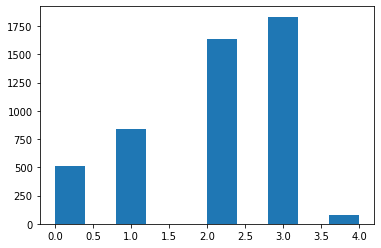

In [77]:
%matplotlib inline
plt.figure()
plt.hist(labels);

In [78]:
labels_old = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')

In [79]:
labels_old = classification.squeeze_integers(labels_old)

In [80]:
last_idx = np.where(~np.isnan(labels))[0].max()

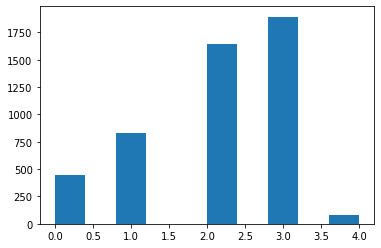

In [81]:
%matplotlib inline
plt.figure()
plt.hist(labels_old[:last_idx]);

In [82]:
idx_labeled = np.where(~np.isnan(labels))[0]

In [103]:
cm = classification.confusion_matrix(labels[idx_labeled].astype(np.int64), labels_old[idx_labeled].astype(np.int64))

<IPython.core.display.Javascript object>


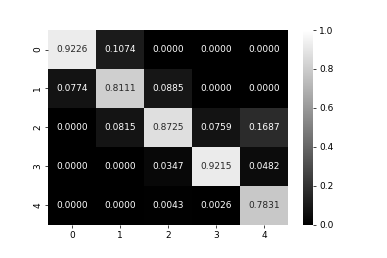

<AxesSubplot:>

In [104]:
import seaborn as sns

# sns.set(font_scale=1.2)
plt.figure()
sns.heatmap(
    cm, 
    fmt='.4f',
    annot=True, 
    vmax=1, 
    vmin=0,
    cmap='gray',
#     font_scale=1.2,
)